In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict

class Portfolio():
    def __init__(self,syms,sym_data):
        self.syms = syms
        self.sym_data = sym_data

class QTrader(object):
    def __init__(self, sym_data, eta=1, transaction_cost=0.005, position=10):
        self.sym_data = sym_data
        self.stock_data = sym_data#pd.merge(pd.read_csv('./tbill.csv', index_col='Date'), pd.read_csv('./^GSPC.csv', index_col='Date'), right_index=True, left_index=True).sort_index()
        ret = self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1)
        # These are price returns and the weekly returns for TBills (3 months)self.stock_data['Close']
        self.returns = pd.DataFrame({
                                        'stocks': self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                                        'tbills': (ret.std()) ,
                                    }, index=self.stock_data.index)

        self.returns['risk_adjusted'] = (self.returns.stocks - self.returns.tbills)
        self.returns['risk_adjusted_moving'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.mean())
        self.returns['risk_adjusted_stdev'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.std())
        self.returns['risk_adjusted_high'] = self.returns.risk_adjusted_moving + 1.5 * self.returns.risk_adjusted_stdev
        self.returns['risk_adjusted_low'] = self.returns.risk_adjusted_moving - 1.5 * self.returns.risk_adjusted_stdev
        self.returns['state'] = (self.returns.risk_adjusted > self.returns.risk_adjusted_high).astype('int') - \
                                (self.returns.risk_adjusted < self.returns.risk_adjusted_high).astype('int') # pd.qcut(self.returns.sharpe_moving, 10, labels=range(10))
    def graph_portfolios(self):

        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint] 
        testing_indexes = self.returns.index[midpoint:]

        portfolios = pd.DataFrame({
            'buy_and_hold': self.buy_and_hold(testing_indexes),
            'buy_tbills': self.buy_tbills(testing_indexes),
            'random': self.random(testing_indexes),
            'qtrader': self.q_holdings(training_indexes, testing_indexes)
            }, index=testing_indexes)

        portfolio_values = pd.DataFrame({
                'buy_and_hold': self.evaluate(portfolios.buy_and_hold),
                'buy_tbills': self.evaluate(portfolios.buy_tbills),
                'random': self.evaluate(portfolios.random),
                'qtrader': self.evaluate(portfolios.qtrader)
            }, index=testing_indexes)
        
        portfolio_values.plot()

        plt.annotate("Buy and hold sharpe: {}\n QTrader sharpe: {}".format(self.sharpe(portfolios.buy_and_hold), self.sharpe(portfolios.qtrader)), xy=(0.25, 0.95), xycoords='axes fraction')
        
        plt.show()
        
    def buy_and_hold(self, dates):
        return pd.Series(1, index=dates)

    def buy_tbills(self, dates):
        return pd.Series(0, index=dates)

    # This will go long or short or do nothing randomly
    def random(self, dates):
        return pd.Series(np.random.randint(-1, 2, size=len(dates)), index=dates)

    def calc_returns(self, holdings):
        return pd.Series(self.returns.tbills + holdings * self.returns.risk_adjusted, index=holdings.index)

    def evaluate(self, holdings):
        return (self.calc_returns(holdings) + 1).cumprod()

    def state(self, first_moment, second_moment):
        return first_moment + second_moment * 10

    def q_holdings(self, training_indexes, testing_indexes):
        factors = pd.DataFrame({'action': 0, 'reward': 0, 'state': 0}, index=training_indexes)

        # Initialize Q matrix
        q = {0: {1:0, 0:0, -1:0}}
        
        # For Dyna-Q
        T = np.zeros((3, 3, 3)) + 0.00001
        R = np.zeros((3,3))

        # Episodes
        for i in range(100):
            last_row, last_date = None, None

            for date, row in factors.iterrows():
                return_data = self.returns.loc[date]
                if return_data.state not in q:
                    q[return_data.state] = {1: 0, 0:0, -1:0}

                if last_row is None or np.isnan(return_data.state):
                    state = 0
                    reward = 0
                    action = 0
                else:
                    state = int(return_data.state)
                    if random.random() > 0.001:
                        action = max(q[state], key=q[state].get)
                    else:
                        action = random.randint(-1,1)

                    reward = last_row.action * (return_data.stocks - return_data.tbills)

                    alpha = 1
                    discount = 0.9

                    factors.loc[date, 'reward'] = reward
                    factors.loc[date, 'action'] = action
                    factors.loc[date, 'state'] = return_data.state

                    update = alpha * (factors.loc[date, 'reward'] + discount * max(q[row.state].values()) - q[state][action])
                    if not np.isnan(update):
                        q[state][action] += update

                    # Dyna
                    action_idx = int(last_row.action+1)
                    state_idx = int(last_row.state+1)
                    new_state_idx = int(state+1)

                    T[state_idx][action_idx][new_state_idx] += 1
                    R[state_idx][action_idx] = (1 - alpha) * R[state_idx][action_idx] + alpha * reward

                last_date, last_row = date, factors.loc[date]

            for j in range(100):
                state_idx = random.randint(0,2)
                action_idx = random.randint(0,2)
                new_state = np.random.choice([-1, 0, 1], 1, p=T[state_idx][action_idx]/T[state_idx][action_idx].sum())[0]
                r = R[state_idx][action_idx]
                q[state][action] += alpha * (r + discount * max(q[new_state].values()) - q[state][action])

            sharpe = self.sharpe(factors.action)

            if sharpe > 0.20:
                break
            #print("For episode {} we get an internal sharpe ratio of {}".format(i, self.sharpe(factors.action)))

        testing = pd.DataFrame({'action': 0, 'state': 0}, index=testing_indexes)
        testing['state'] = self.returns.loc[testing_indexes, 'state']
        testing['action'] = testing['state'].apply(lambda state: max(q[state], key=q[state].get))

        print(self.sharpe(testing.action))

        return testing.action

    def discretize(self, number, steps):
        return 0

    def sharpe(self, holdings):
        returns = holdings * (self.returns.stocks - self.returns.tbills)

        return np.nanmean(returns) / np.nanstd(returns)

    


In [2]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))


def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs



def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))


# Generate portfolios

In [15]:
now = str(current_milli_time())
def intv_port(freq_df,intv):
    dates = freq_df.index.get_level_values('Date').drop_duplicates()

    coins = freq_df.index.get_level_values('Coin')
    date_int = pd.DataFrame({"Date":[d.strftime('%Y-%m-%d') for d in dates]})
    date_int = date_int.drop_duplicates()
    date_int = date_int.astype('datetime64[s]')
    intv_dates = list(date_int.Date[::intv])
    port = pd.DataFrame()
    for c,day in enumerate(intv_dates):
        try:
            st,end = day,intv_dates[c+1]
            print(st,end)
            curr = freq_df.loc[st:end].reset_index()
            curr['Date'] = end

        except Exception as e:
            #print(e)
            break

        curr['all_freq'] = curr.groupby('Coin')['Coin'].transform('count')
        curr = curr[['Date','Coin','Close','all_freq']].sort_values("all_freq",ascending=False)
        curr = curr.sort_values(['Date'],ascending=False)
        curr = curr.set_index('Date')
        port_coins = curr.Coin.drop_duplicates()
        c_group = curr.groupby('Coin')
        curr_port = pd.DataFrame()
        for pc in port_coins:
            curr = c_group.get_group(pc).head(1)
            curr_port = pd.concat([curr_port,curr])
            curr_port = curr_port.sort_values("all_freq",ascending=False).head(9)
        port = pd.concat([port,curr_port])

    port = port.reset_index()
    port['Date'] = port['Date'].astype('datetime64[s]')
    #print(port['Date'])
    d2 = [d.strftime('%Y-%m-%d') for d in port.Date]
    port['Date'] = d2
    port = port.set_index(['Date','Coin'])
    return port

#get freq. signal df
freq_loc = '/home/me/Documents/BWA/data/freq_concat.csv'
fs = pd.read_csv(freq_loc)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
str_intv = input("portfolio interval: ")
intv = int(str_intv)
port = intv_port(fs_c,intv)
port = port.sort_values(['Date','all_freq'],ascending=[True,False])
port.to_csv("/home/me/Documents/BWA/data/{}day_portfolio.csv".format(intv))


portfolio interval: 2
2018-08-24 00:00:00 2018-08-26 00:00:00
2018-08-26 00:00:00 2018-08-28 00:00:00
2018-08-28 00:00:00 2018-09-03 00:00:00
2018-09-03 00:00:00 2018-09-05 00:00:00
2018-09-05 00:00:00 2018-09-07 00:00:00
2018-09-07 00:00:00 2018-09-09 00:00:00
2018-09-09 00:00:00 2018-09-11 00:00:00
2018-09-11 00:00:00 2018-09-13 00:00:00
2018-09-13 00:00:00 2018-09-15 00:00:00
2018-09-15 00:00:00 2018-09-17 00:00:00
2018-09-17 00:00:00 2018-09-19 00:00:00
2018-09-19 00:00:00 2018-09-21 00:00:00
2018-09-21 00:00:00 2018-09-23 00:00:00
2018-09-23 00:00:00 2018-09-25 00:00:00
2018-09-25 00:00:00 2018-09-27 00:00:00
2018-09-27 00:00:00 2018-09-29 00:00:00
2018-09-29 00:00:00 2018-10-01 00:00:00
2018-10-01 00:00:00 2018-10-03 00:00:00
2018-10-03 00:00:00 2018-10-05 00:00:00
2018-10-05 00:00:00 2018-10-07 00:00:00
2018-10-07 00:00:00 2018-10-09 00:00:00
2018-10-09 00:00:00 2018-10-11 00:00:00
2018-10-11 00:00:00 2018-10-13 00:00:00
2018-10-13 00:00:00 2018-10-15 00:00:00
2018-10-15 00:00:0

# Analyze portfolio

In [72]:
def sig_trader(signals,coin):
    sigs = signals.copy()
    #sigs['longs'] = 0.0
    #sigs["stops"] = 0.0
    sigs['trades'] = 0.0
    for c,r in enumerate(sigs):
        if(c==0):
            continue
        c_price = sigs[coin].iloc[c]
        l_price = sigs[coin].iloc[c-1]
        ma2 = sigs["2"].iloc[c]
        ma1 = sigs["1"].iloc[c]
        man1 = sigs["-1"].iloc[c]
        man2 = sigs["-2"].iloc[c]
        if(l_price<man2 and c_price>man2):
            sigs["trades"].iloc[c] = 1
        if(c_price<(man2-(man2*.05))):
            sigs["trades"].iloc[c] = -1
    return sigs
            
        
def backtest(signals,coin):
    # Set the initial capital
    initial_capital= 1.0
    size = initial_capital/10
    # Create a DataFrame `positions`
    
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions["size"] = size
    positions[coin] = signals[coin]
    
    # Buy a 100 shares
    #calc share amt
    #print("im good")
    #print(positions.head())
    share = positions["size"]/positions[coin]
    cname = str(coin)+""
    #print("im good")
    positions["share"] = share.values*signals['signal'].values
    
    # Initialize the portfolio with value owned   
    portfolio = positions.multiply(signals[coin], axis=0)
    # Store the difference in shares owned 
    pos_diff = positions.diff()
    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(signals[coin], axis=0)).sum(axis=1)
    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(signals[coin], axis=0)).sum(axis=1).cumsum()   
    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    # Add `returns` to portfolio
    portfolio['returns'] = portfolio['total'].pct_change()

    # Print the last lines of `portfolio`
    print(portfolio.iloc[-1])
    return portfolio

    

Index(['2019-03-30', '2019-04-01'], dtype='object', name='Date')
2019-03-30 00:00:00 2019-04-01 00:00:00


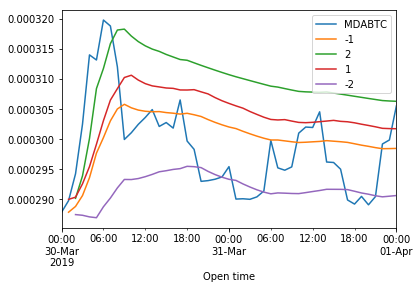

size        3.055000e-05
MDABTC      9.333025e-08
share       0.000000e+00
holdings    3.064333e-05
cash        1.000939e+00
total       1.000969e+00
returns     1.883161e-03
Name: 2019-04-01 00:00:00, dtype: float64


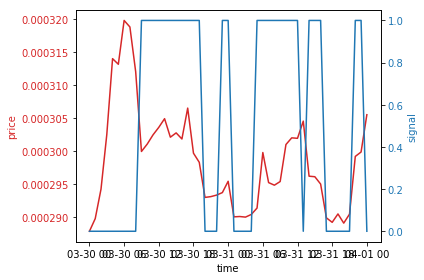

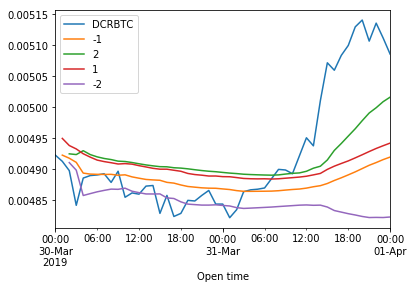

size        0.000509
DCRBTC      0.000026
share       0.000000
holdings    0.000534
cash        0.997620
total       0.998154
returns    -0.000003
Name: 2019-04-01 00:00:00, dtype: float64


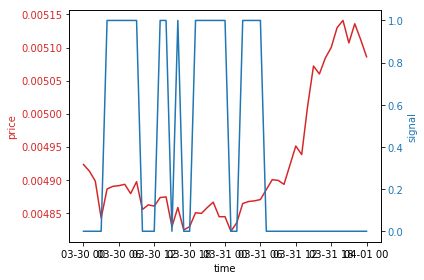

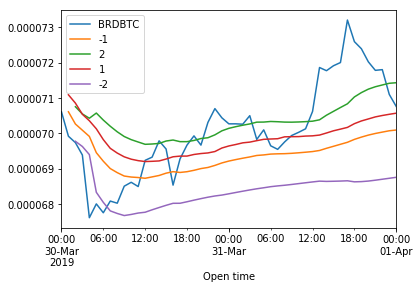

size        7.076000e-06
BRDBTC      5.006978e-09
share       0.000000e+00
holdings    7.081007e-06
cash        1.003742e+00
total       1.003749e+00
returns    -3.389708e-08
Name: 2019-04-01 00:00:00, dtype: float64


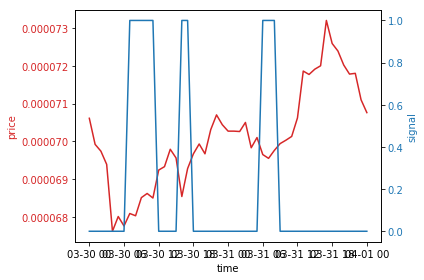

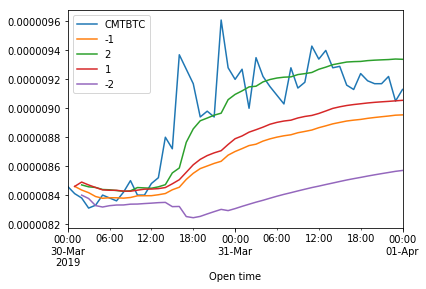

size        9.130000e-07
CMTBTC      8.335690e-11
share       0.000000e+00
holdings    9.130834e-07
cash        1.003868e+00
total       1.003869e+00
returns     8.813553e-04
Name: 2019-04-01 00:00:00, dtype: float64


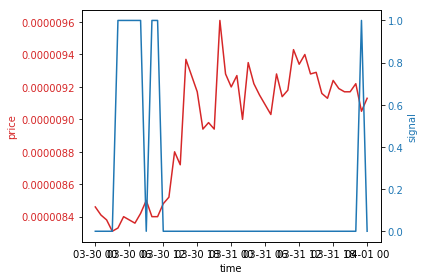

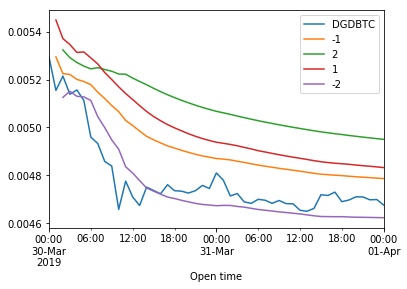

size        0.000468
DGDBTC      0.000022
share       0.100000
holdings    0.100489
cash        0.893617
total       0.994106
returns    -0.000495
Name: 2019-04-01 00:00:00, dtype: float64


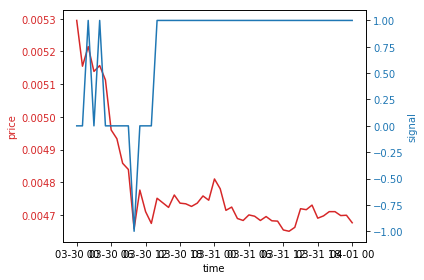

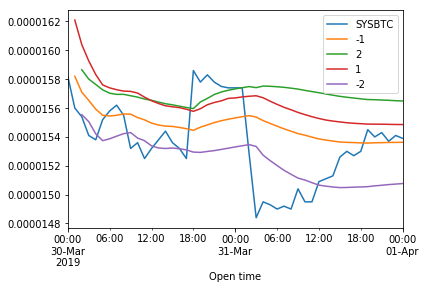

size        1.539000e-06
SYSBTC      2.368521e-10
share       1.000000e-01
holdings    1.000015e-01
cash        8.998506e-01
total       9.998521e-01
returns    -1.297902e-04
Name: 2019-04-01 00:00:00, dtype: float64


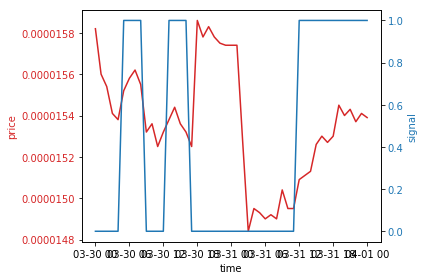

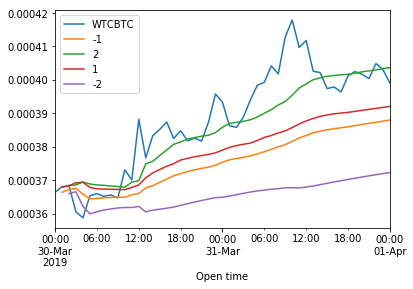

size        3.991000e-05
WTCBTC      1.592808e-07
share       0.000000e+00
holdings    4.006928e-05
cash        9.999401e-01
total       9.999801e-01
returns    -4.016202e-07
Name: 2019-04-01 00:00:00, dtype: float64


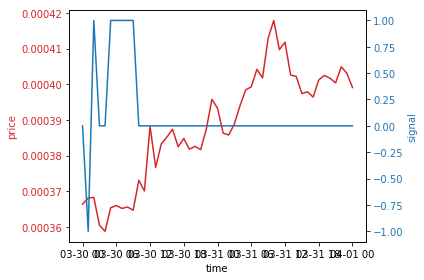

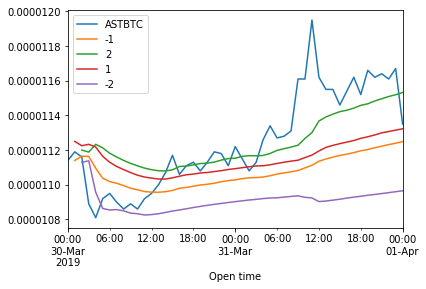

size        1.135000e-06
ASTBTC      1.288225e-10
share       0.000000e+00
holdings    1.135129e-06
cash        9.994040e-01
total       9.994051e-01
returns    -3.202278e-08
Name: 2019-04-01 00:00:00, dtype: float64


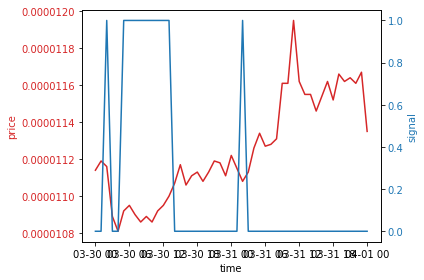

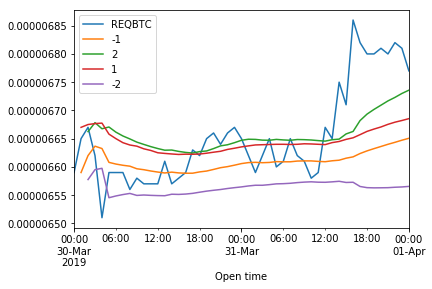

size        6.770000e-07
REQBTC      4.583290e-11
share       0.000000e+00
holdings    6.770458e-07
cash        1.000627e+00
total       1.000628e+00
returns    -3.997762e-09
Name: 2019-04-01 00:00:00, dtype: float64


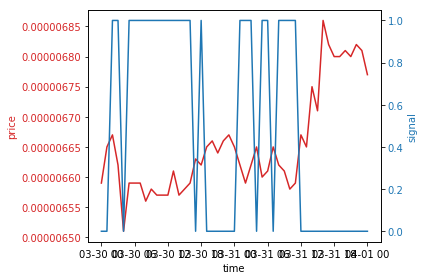

In [73]:
import ffn
p_dates = port.index.get_level_values('Date').drop_duplicates()
returns = []
all_ports = pd.DataFrame()
lastn = p_dates[-2:]
print(lastn)
for c,d in enumerate(lastn):
    if(c>len(lastn)-1):
        break
    try:
        st = datetime.datetime.strptime(d, '%Y-%m-%d')
        end = datetime.datetime.strptime(lastn[c+1], '%Y-%m-%d')
        print(st,end)
        
        st,end = int(unix_time_millis(st)),int(unix_time_millis(end))
        prev_st = st-86400000*intv
        curr_port = port.loc[d]
        p_coins = curr_port.index.get_level_values('Coin').values
        curr_port_hist = pd.DataFrame()
        for coin in p_coins:
            #current hist ...lazy way
            #c_hist = get_data(coin,st,end,candle_k='1h')
            #btc_hist = get_data('BTCUSDT',st,end,candle_k='1h')
            #q trader hist with prior data for training
            q_hist = get_data(coin,st,end,candle_k='1h')
            prices = pd.DataFrame()
            high = q_hist.High
            prices[coin] = q_hist['Close']
            
            

            # Compute the cumulative moving average of the price
            
            prices['-1'] = [prices[coin][:i].mean() for i in range(len(prices))]
            vol = [prices[coin][:i].std() for i in range(len(prices))]
            ch = [high[:i].mean() for i in range(len(high))]
            prices['2'] = prices['-1'] + vol
            prices['1'] = ch
            prices['-2'] = prices['-1'] -vol
            #trades = sig_trader(prices,coin)
            #print(trades)
            prices.plot()
            plt.show()
            #break
            
            
            
            signals = prices.copy()
            #p over 2
            signals["p>2"] = np.where(signals[coin]>signals["2"],1.0,0.0)
            #p over 1
            signals["p>1"] = np.where(signals[coin]>signals["1"],1.0,0.0)
            #p over-1
            signals["p>-1"] = np.where(signals[coin]>signals["-1"],1.0,0.0)
            #p over -2
            signals["p>-2"] = np.where(signals[coin]>signals["-2"],1.0,0.0)
            # -2 stop loss with -5% risk adj
            signals['stop'] = signals["-2"]-(signals["-2"]*.05)
            # -1 stop for 1 crossver
            signals['stop2'] = signals["-1"]
            #shorts below stoploss
            signals['short'] = np.where(signals[coin]<signals["stop"],-1.0,0.0)
            #shorts before stoploss 2
            signals['short2'] = np.where(signals[coin]<signals["stop2"],-1.0,0.0)
            #long above -1
            signals['long'] = signals["p>-2"]-signals["p>-1"]
            #long 2 above 1
            signals['long2'] = signals["p>1"]-signals["p>2"]
            #exit at between 1 and -1
            signals['exit'] = signals["p>-1"]-signals["p>1"]
            #exit at crossover 2 *1%
            signals['exit2'] = signals["p>2"]-(signals["p>2"]+(signals["p>2"]*.01)) #sell 50% take profit 
            #signals['exit'] = np.where(signals[coin]>=signals["exit"],-1.0,0.0)
            signals['positions'] = signals['short']+signals['long']+signals['exit']
            signals['positions2'] = signals['short2']+signals['long2']+signals['exit2']
            #print(signals[[coin,'long','short','exit','positions']])
            prices['returns'] = np.log(prices[coin] / prices[coin].shift(1))
            #signals['positions'] = signals['positions']+signals['positions2']
            prices["signal"] = signals['positions']
            prices["positions"] = signals['positions'].diff()
            bt = backtest(prices,coin)
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('time')
            ax1.set_ylabel('price', color=color)
            ax1.plot(signals[coin],color=color)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

            color = 'tab:blue'
            ax2.set_ylabel("signal", color=color)  # we already handled the x-label with ax1
            ax2.plot(signals["positions"], color=color)
            ax2.tick_params(axis='y', labelcolor=color)

            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.show()

            """
            #0 menas start with no pos, 1 has position
            signals['trend'] = np.where(signals[coin].rolling(3).mean().fillna(0)<signals[coin],1.0,0.0)
            signals["shorts"] = signals["p>2"]-signals["p>1"]
            signals['sig'] = signals['p>2']+signals['p>1']+signals['p>-1']+signals['p>-2']+signals['trend']
            signals['sig_change'] = signals['sig'].diff()
            signals['sig_avg'] = signals['sig'].rolling(9).mean().fillna(3)
            signals['sig_avg'] = signals['sig_avg'].astype(int)
            """
            #print(signals[[coin,'sig','sig_change','sig_avg']].head())
            #print(signals[['p>2','p>1','p>-1','p>-2','trend']].head())
            
            
            #break
            
            
        plt.show()
        break
        

        #perf = ffn.calc_stats(curr_port_hist)
        #curr_port_hist.cumsum().plot()
        #plt.show()
        #all_ports = pd.concat([all_ports,curr_port_hist],axis=0)
        #print(curr_port_hist.head()) 
        #print(p_coins)
        
    except Exception as e:
        print(e)
        pass

#all_ports= all_ports.fillna(0)
#all_ports.to_csv(fname+"all_coins.csv")


all_ports

In [18]:
p_dates[-3:]

Index(['2019-03-28', '2019-03-30', '2019-04-01'], dtype='object', name='Date')

In [9]:
port

Close  all_freq
Date       Coin                        
2018-09-11 MODBTC    0.000148       513
           SNMBTC    0.000009       500
           DNTBTC    0.000003       385
           BTGBTC    0.003065       355
           AEBTC     0.000159       323
           KMDBTC    0.000169       307
           NASBTC    0.000232       292
           VIABTC    0.000126       285
           WAVESBTC  0.000297       239
2018-09-25 BTGBTC    0.003268       413
           XMRBTC    0.018114       369
           ZENBTC    0.002402       314
           GRSBTC    0.000083       223
           KMDBTC    0.000171       220
           THETABTC  0.000013       219
           MODBTC    0.000106       205
           GASBTC    0.000792       204
           ZECBTC    0.018347       178
2018-10-09 ZENBTC    0.002530       447
           XMRBTC    0.017491       446
           NULSBTC   0.000179       306
           NXSBTC    0.000130       298
           DGDBTC    0.005769       254
           PIVXBTC   0.000163       253
           DASHBTC   0.028662       229
           XZCBTC    0.001402       213
           BTGBTC    0.003858       179
2018-10-23 XMRBTC    0.015940       365
           BTGBTC    0.004026       296
           MDABTC    0.000329       245
...                       ...       ...
2019-02-15 RDNBTC    0.000059       202
           EVXBTC    0.000083       201
           PPTBTC    0.000340       178
2019-03-01 MDABTC    0.000206       347
           RDNBTC    0.000065       313
           REPBTC    0.003734       271
           THETABTC  0.000025       186
           WINGSBTC  0.000014       176
           XZCBTC    0.001394       174
           ENGBTC    0.000087       170
           GNTBTC    0.000017       160
           ELFBTC    0.000032       156
2019-03-18 MDABTC    0.000227       306
           APPCBTC   0.000019       157
           RDNBTC    0.000086       142
           NULSBTC   0.000113       138
           STRATBTC  0.000219       126
           BCPTBTC   0.000010       123
           WABIBTC   0.000056       122
           XMRBTC    0.012636       116
           NEBLBTC   0.000302       116
2019-04-01 MDABTC    0.000300       676
           DCRBTC    0.004858       241
           MTHBTC    0.000005       232
           LSKBTC    0.000381       204
           XZCBTC    0.001661       183
           OAXBTC    0.000040       138
           LOOMBTC   0.000018       137
           ELFBTC    0.000044       133
           LRCBTC    0.000016       133

[135 rows x 2 columns]

In [ ]:
p_dates = port.index.get_level_values('Date').drop_duplicates()
returns = []
all_ports = pd.DataFrame()
for c,d in enumerate(p_dates[:-3]):
    if(c>len(p_dates)-1):
        break
    try:
        st = datetime.datetime.strptime(d, '%Y-%m-%d')
        end = datetime.datetime.strptime(p_dates[c+1], '%Y-%m-%d')
        print(st,end)
        
        st,end = int(unix_time_millis(st)),int(unix_time_millis(end))
        prev_st = st-86400000*intv
        curr_port = port.loc[d]
        p_coins = curr_port.index.get_level_values('Coin').values
        curr_port_hist = pd.DataFrame()
        for coin in p_coins:
            #current hist ...lazy way
            #c_hist = get_data(coin,st,end,candle_k='1h')
            #btc_hist = get_data('BTCUSDT',st,end,candle_k='1h')
            #q trader hist with prior data for training
            q_hist = get_data(coin,st,end,candle_k='1h')